<a href="https://colab.research.google.com/github/stefanogiagu/AI_INFN/blob/main/2025/MoE_GT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mixture-of-experts graph transformers for interpretable particle collision detection

*2nd AI_INFN Hachathon - Pavia 24-27/11/2025*

**Topic:** MoE GraphTransformers (D.Genovese, A.Sgroi, A.Devoto, S.Valentine, L.Wood, C.Sebastiani, S.Scardapane, M.D'Onofrio, S.Giagu,  "Mixture-of-experts graph transformers for interpretable particle collision detection", [Sci Rep 15, 27906 (2025)](https://link.springer.com/article/10.1038/s41598-025-12003-9)), combine a Graph Transformer model ([arXiv:2021.09699](https://arxiv.org/abs/2012.09699)) with Mixture-of-Expert layers ([arXiv:1701.06538](https://arxiv.org/abs/1701.06538)) to achieve high predictive performance while embedding explainability into the architecture.

**Example application:** Classification of high energy decays (Exotic Higgs decays $H^0(425) \to WH^+(325) \to WWh^0(125)\to WWb\bar{b}\to l\nu qq'b\bar{b}$ final states, vs SM $t\bar{t}\to WWb\bar{b}\to l\nu qq'b\bar{b}$). **Public dataset** from  P.Baldi, P.Sadowsky, D. Whiteson, "Searching for exotic particles in high-energy physics with deep learning", [Nat Commun 5, 4308 (2014)](https://www.nature.com/articles/ncomms5308).

**Exercise steps:**
1. read and preprocess dataset to create events fully connected graphs (sets), with Laplacian spectral positional encoding ([arXiv:2106.03893](https://arxiv.org/pdf/2106.03893));
2. design a MoE Graph-Transformer (MoE-GT) architecture;
3. training and performance assesment;
4. exaple of analysis of the experts' utilisation and of the attention heat-maps.

**Note:** set and coded to be fully run (train + test) in less than ~30 minutes on gogle colab using a Nvidia T4 GPU

**Notebook Version:** V1.0 **author:** <stefano.giagu@uniroma1.it>

In [1]:
#@title 1. Setup software [average running time in google colab: ~50 seconds]
import torch
print(torch.__version__)


#install pytorch geometric libraries in google colab
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster torch-spline-conv --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

2.8.0+cu126
Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 114.6 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.7 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 65.4 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 24.4 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-06riwbx5
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-06riwbx5
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 2f182dc6fde74bb04a67b5812dd5ee94aaf92092
  Installing build dependencies ... done
  Getting requirements to bui

In [2]:
#@title 2. Import libraries [average running time in google colab: ~1 second]
import math, torch, numpy as np, matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import CosineAnnealingLR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Torch', torch.__version__, '| device →', device)

Torch 2.8.0+cu126 | device → cuda


In [5]:
#@title 3. Load `data_HiggsDS.npz` & create splits & [average running time in google colab: ~10 seconds]

# Higgs dataset from paper: "Searching for exotic particles in high-energy
# physics with deep learning", P.Baldi, P.Sadowsky, D. Whiteson, Nat Commun 5, 4308 (2014)

# Dataset description:
# 24 features: lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi,
# jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag,
# jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag,
# jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag,
# jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag,
# reconstructed mass m_bb, reconstructed mass m_Wbb, reconstructed mass m_WWbb

# NOTE: all features have been standardized over the entire training/test set
# with mean 0 and sdev 1, except for those features with values strictly >0,
# these have been scaled so that the mean value was 1.

# download dataset (numpy compressed)
!wget -N http://giagu.web.cern.ch/giagu/CERN/data_higgsDS.npz

npz = np.load('data_higgsDS.npz')
X_all = npz['features'].astype('float32')
y_all = npz['labels'  ].astype('int64')

print('Dataset shape:', X_all.shape)

# train / val / test = 80 / 10 / 10 %
n   = 400000 #number of events used for the exercises (kept low to reduce running time)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = n - n_train - n_val


idx   = np.random.permutation(len(X_all))
X_all = X_all[idx];  y_all = y_all[idx]

X_all = X_all[:n]
y_all = y_all[:n]

print('Used dataset shape:', X_all.shape, '\n')

print('Split sizes:', n_train, n_val, n_test)

# standardisation on train only
scaler = StandardScaler().fit(X_all[:n_train])
X_all  = scaler.transform(X_all).astype('float32')

--2025-08-22 09:05:28--  http://giagu.web.cern.ch/giagu/CERN/data_higgsDS.npz
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.185.50.104, 188.185.5.88, 137.138.55.232, ...
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.185.50.104|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://giagu.web.cern.ch/giagu/CERN/data_higgsDS.npz [following]
--2025-08-22 09:05:29--  https://giagu.web.cern.ch/giagu/CERN/data_higgsDS.npz
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.185.50.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132168641 (126M)
Saving to: ‘data_higgsDS.npz’

data_higgsDS.npz    100%[===================>] 126.04M  22.4MB/s    in 6.9s    

2025-08-22 09:05:36 (18.2 MB/s) - ‘data_higgsDS.npz’ saved [132168641/132168641]

Dataset shape: (1691147, 24)
Used dataset shape: (400000, 24) 

Split sizes: 320000 40000 40000


In [6]:
# Laplacian positional encoding [average running time in google colab: ~0 seconds]

# Transformers rely on order to know where a token sits in a sequence.
# When dealing with graphs there is a problem, as graphs are unordered collections
# of nodes, so there is no inherent “first” or “last” node.
# To feed a graph into a transformer-style architecture like the GT we want to use
# we give each node a coordinate vector that captures where it lives inside the graph
# topology. These coordinates are called graph positional encodings.
# A smart technique to find PE coordinates for graphs is the Laplacian positional encoding (LPE),
# that realy on spectral properties of the graph to identify gloabl structure of the graph.

# Definition:
# given the graph G = (V,E) with |V|=N, we define the Adjacency matrix A:A_ij=1 if (i,j)\in E,
# otherwise A_ij=0; and the Degree matrix D = diag(d_1, ..., d_N), where d_i = Sum_j A_ij

# the Combinatorial Laplacian matrix L is defined as: L = D - A
# it is symmetric positive-semidefinite and plays for graphs the same role the
# second-derivative (Laplacian) plays on continuous domains.

# We can decompose L on his eigenvalues:
# Lu_k = lambda_k u_k   with  0 <= lambda_0 <= lambda_1 <= .... <= lambda_N-1
# with u_0 = 1\sqrt(N) (1,...,1)^T is the trivial constant vector, and
# u_2,...,u_N-1 are an orthonrmal basis function over the graph (analogs of sine/cosine in
# Fourier analysis).

# LPE procedure:
# choose a small number k (e.g. 4–16)
# Stack the first k non-trivial eigenvectors into a matrix: PE = [u_1, ..., u_k] \in R^Nxk
# each node i of the graph now has k-dimensional coordinate: PE_i = (u_1(i), ..., u_j(i))

# Advantages:
# - the LPE provides the model with a geometry-aware notion of “position” instead of simple sequence order.
# - low-frequency eigenvectors vary slowly across the graph; they capture coarse clusters and
# long-range relationships—information that vanilla node features lack;
# - as the Laplacian matrix depends only on G, then PE is permutation-equivariant:
# reorder nodes → reorder rows → transformer sees the same geometry;
# - recent studies show that Laplacian PEs let transformers distinguish graphs
# that message-passing GNNs cannot (eg increases the expressive power of the model).


# function that returns (N, k) matrix of Laplacian eigenvectors
def laplacian_pe(num_nodes=24, k=4):
    A = torch.ones(num_nodes, num_nodes) - torch.eye(num_nodes)  # fully-connected (matrix with all 1s but the diagonal)
    D = torch.diag(A.sum(1))
    L = D - A
    eigvals, eigvecs = torch.linalg.eigh(L)         # (N,), (N,N)
    return eigvecs[:, 1:k+1].float()                # drop the trivial eigenvector
PE_FIXED = laplacian_pe()                           # shape (24, 4)

In [7]:
#@title 4. PyTorch Dataset & DataLoaders [average running time in google colab: ~0 seconds]

class HiggsGraphDataset(Dataset):
#Treat each event as a fully-connected graph with 24 nodes, one scalar feature per node.
    def __init__(self, X, y, pe=PE_FIXED):
        self.X = X.reshape(-1, 24, 1)    # (B, N=24, F=1)
        #Laplacian PE
        self.pe = pe.unsqueeze(0).repeat(len(X), 1, 1)  # broadcast to batch
        self.y = y
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        x_node = torch.from_numpy(self.X[i])        # (N,1)
        x = torch.cat([x_node, self.pe[i]], dim=-1) # now (N, 1+pe_dim)
        return x, torch.tensor(self.y[i])

ds_train = HiggsGraphDataset(X_all[:n_train], y_all[:n_train])
ds_val   = HiggsGraphDataset(X_all[n_train:n_train+n_val], y_all[n_train:n_train+n_val])
ds_test  = HiggsGraphDataset(X_all[n_train+n_val:n_train+n_val+n_test], y_all[n_train+n_val:n_train+n_val+n_test])

train_loader = DataLoader(ds_train, batch_size=1024, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(ds_val,   batch_size=4096, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(ds_test,  batch_size=4096, shuffle=False, num_workers=2, pin_memory=True)

print(f'Events → train:{len(ds_train)}  val:{len(ds_val)}  test:{len(ds_test)}')

Events → train:320000  val:40000  test:40000


In [8]:
#@title 5. Graph-Transformer + Mixture-of-Experts Architecture [average running time in google colab: ~0 seconds]

# Architecture scheme:
#
#          token features (T, d_model)
#                     │
#          ┌──────────┴──────────┐
#          ▼                     ▼
#   Noisy-Top-K router       load-balancing
#(select k experts/token)        loss
#          │
#          ├── indices  ─────────► (analysis only)
#          └── gates   ┐
#                      ▼
#        ┌───────────────────────────┐
#        │  Expert 0   Expert 1  …   │   (E experts in parallel)
#        │   MLP        MLP          │
#        └───────────────────────────┘
#                      ▲
#         weighted sum │ (sparse: only k experts/tok)
#                      ▼
#         combined output (T, d_model)
#                      │
#          residual + LayerNorm, etc.



# ---------- Router --------------------------------------------------------------
# router scope: is the heart of the MoE architecture. His task is to decide,
# for each token, which subset of experts it should be routed to, and with what
# importance (the so called gating weights).

# In practice implements the function G(x): G(x) = Softmax(KeepTopK(H(x),k)) in which
# H(x) is a score function that includes learned expert scores plus noise. This allows the model
# to learn during traning which experts are relevant for a token and encourages diverse routing.

# In practice the NoisyTopKRouter module implements the following steps:
# 1: assigns a score to each expert for every token
# 2: adds noise to encourage exploration
# 3: selects the top-k scoring experts
# 4: applies a softmax to produce routing weights
# 5: outputs an auxiliary load-balancing loss, in order to avoid expert collapse

#
class NoisyTopKRouter(nn.Module):
    def __init__(self, d_model, n_experts, k=2, w_load=1.0):
        super().__init__()
        self.k, self.w_load = k, w_load #k and weight for the load balancing loss
        self.wg     = nn.Linear(d_model, n_experts, bias=False) #linear projection: score how well each expert fits the token (learned scores)
        self.w_noise= nn.Linear(d_model, n_experts, bias=False) #learn a noise scale per expert, per token

    def forward(self, x):
        # input: x (T, d) <- token embedding
        # outputs:
        #   gates: (T, k)     <- softmax weights for top-k experts
        #   indices: (T, k)   <- which experts were selected
        #   lb_loss: scalar   <- load-balancing loss
        logits  = self.wg(x) # linear projection: score how well each expert fits the token
        noise   = torch.randn_like(logits)
        logits += F.softplus(self.w_noise(x)) * noise  #encourages exploration during training, avoids premature convergence to a few experts

        # select top-k experts
        topk_log, topk_idx = torch.topk(logits, self.k, -1) # (T,k) select the best k experts for this token
        gates = F.softmax(topk_log, -1)                     # (T,k) Compute routing weights among those k experts

        # Compute load-balancing loss to ensure the even utilization of the experts
        probs   = torch.sigmoid(logits - topk_log[:, [-1]]) # P(x,i)
        loads   = probs.sum(0) # total load per expert
        lb_loss = self.w_load * loads.var() / (loads.mean()**2 + 1e-9)  # Eq.(6) encourages equal usage of all experts (so some don't die out)

        return gates, topk_idx, lb_loss

# ---------- Experts -------------------------------------------------------------
# expert scope: in a MoE layer each input token is routed to a small subset (typically just two)
# of parallel neural networks called experts. Instead of every token passing through a single shared
# feed-forward network as in a normal Transformer, the router module decides which expert(s) should process
# which tokens.
# each expert is a 2-layers MLP with LeakyReLU non-linearity, and it is a stanadlone MLP (eg parameters are not shared
# across experts)

# tokens are processed batch-wise so that GPU utilisation remains efficient even when different tokens choose
# different experts.

class Expert(nn.Module):
    def __init__(self, d_model, d_hidden=20):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_hidden), #expansion (like in stadard transformers)
            nn.LeakyReLU(inplace=True),   #non-linearity
            nn.Linear(d_hidden, d_model)  #projecton back
        )
    def forward(self, x): return self.net(x)

# ---------- MoE -----------------------------------------------------------------
class MoE(nn.Module):
    def __init__(self, d_model, n_experts=6, k=2, d_hidden=20):
        super().__init__()
        self.router  = NoisyTopKRouter(d_model, n_experts, k)
        self.experts = nn.ModuleList([Expert(d_model, d_hidden) for _ in range(n_experts)])

    def forward(self, x, trace=False):
        gates, idx, lb_loss = self.router(x)             # (T,k)
        y = torch.zeros_like(x)

        for hop in range(gates.size(1)):
            e_idx = idx[:, hop]
            for e in range(len(self.experts)):
                sel = e_idx == e
                if sel.any():
                    y[sel] += gates[sel, hop:hop+1] * self.experts[e](x[sel])

        return (y, lb_loss, (gates.detach(), idx.detach())) if trace else (y, lb_loss)
# ---------- Attention block -----------------------------------------------------
class GraphMultiHeadAttention(nn.Module):
    def __init__(self, d_model, heads):
        super().__init__()
        assert d_model % heads == 0
        self.dk, self.h = d_model // heads, heads
        self.q = nn.Linear(d_model, d_model); self.k = nn.Linear(d_model, d_model)
        self.v = nn.Linear(d_model, d_model); self.o = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):                      # x (B,N,d)
        B,N,_ = x.size(); h,dk = self.h,self.dk
        q = self.q(x).view(B,h,N,dk)
        k = self.k(x).view(B,h,N,dk)
        v = self.v(x).view(B,h,N,dk)
        attn = (q @ k.transpose(-1,-2)) / math.sqrt(dk)
        if mask is not None: attn = attn.masked_fill(mask[:,None]==0, -1e9)
        attn = attn.softmax(-1)
        return self.o((attn @ v).transpose(1,2).reshape(B,N,-1)), attn   # return attn for explain
# ---------- Graph Transformer block ---------------------------------------------------
class GTBlock(nn.Module):
    def __init__(self, d_model=64, heads=2, n_experts=6, k=2, d_expert=20, p_drop=0.):
        super().__init__()
        self.attn  = GraphMultiHeadAttention(d_model, heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.moe   = MoE(d_model, n_experts, k, d_expert)
        self.norm2 = nn.LayerNorm(d_model)
        self.drop  = nn.Dropout(p_drop)

    def forward(self, x, mask=None, explain=False):
        attn_out, attn_map = self.attn(x, mask)
        x = self.norm1(x + self.drop(attn_out))
        if explain:
            y, lb, rt = self.moe(x.flatten(0,1), trace=True)
            y = y.view_as(x); x = self.norm2(x + self.drop(y))
            return x, lb, attn_map.detach(), rt
        else:
            y, lb = self.moe(x.flatten(0,1))
            y = y.view_as(x); x = self.norm2(x + self.drop(y))
            return x, lb
# ---------- Complete model ------------------------------------------------------
class GraphTransformerMoE(nn.Module):
    def __init__(self, in_dim=5, d_model=64, layers=2, heads=2,
                 n_experts=6, k=2, d_expert=20):
        super().__init__()
        self.in_proj = nn.Linear(in_dim, d_model)
        self.blocks  = nn.ModuleList([
            GTBlock(d_model, heads, n_experts, k, d_expert) for _ in range(layers)
        ])
        self.cls_head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, 2)
        )

    def forward(self, x, mask=None, explain=False):
        # x (B,N,1)
        x = self.in_proj(x)
        lb_losses, atts, rts = [], [], []
        for blk in self.blocks:
            if explain:
                x, lb, att, rt = blk(x, mask, explain=True)
                atts.append(att); rts.append(rt)
            else:
                x, lb = blk(x, mask)
            lb_losses.append(lb)
        g = x.mean(1)                 # global mean pooling
        return self.cls_head(g), torch.stack(lb_losses).mean(), (atts, rts) if explain else None

In [9]:
#@title 6. Training loop [average running time in google colab for 60 epochs: ~25-30 min on T4 GPU]

import time
# instantiate model and define loss, optimizer, and scheduler
model = GraphTransformerMoE().to(device)

crit  = nn.CrossEntropyLoss() #x-entropy loss
opt   = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5) #AdamW
sched = CosineAnnealingLR(opt, T_max=60) #cosine learning rate scheduler

num_epochs = 60

best_val = 1e9; best_state = None
history = {'train':[], 'val':[]}

# ---- epoch loop ------------------------------------------------------------
for epoch in range(1, num_epochs+1):
    t0 = time.time()

    # ---- train loop --------------------------------------------------------
    model.train(); running = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits, lb, _ = model(xb) #model prediction
        loss = crit(logits, yb) + lb #compute loss
        opt.zero_grad(); loss.backward(); opt.step() #bakprop and weight update
        running += loss.item() * yb.size(0)
    sched.step()

    # ---- validation loop ----------------------------------------------------
    model.eval(); val_loss = 0
    correct = total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits, lb, _ = model(xb)
            loss = crit(logits, yb) + lb
            val_loss += loss.item() * yb.size(0)
            pred = logits.argmax(1)
            correct += (pred == yb).sum().item(); total += yb.size(0) #accuracy

    train_loss = running / len(ds_train)
    val_loss   = val_loss / len(ds_val)
    val_acc    = correct / total
    history['train'].append(train_loss); history['val'].append(val_loss)

    # save best model
    if val_loss < best_val:
        best_val, best_state = val_loss, model.state_dict()

    elapsed_time = time.time()-t0

    print(f'Epoch {epoch:02d} | time {elapsed_time:.2f} | train loss {train_loss:.4f} | val loss {val_loss:.4f} | val acc {val_acc:.3f}')

Epoch 01 | time 25.77 | train loss 0.6505 | val loss 0.6112 | val acc 0.665
Epoch 02 | time 25.36 | train loss 0.5998 | val loss 0.5940 | val acc 0.684
Epoch 03 | time 25.42 | train loss 0.5884 | val loss 0.5830 | val acc 0.694
Epoch 04 | time 32.95 | train loss 0.5834 | val loss 0.5804 | val acc 0.695
Epoch 05 | time 26.01 | train loss 0.5806 | val loss 0.5780 | val acc 0.695
Epoch 06 | time 25.56 | train loss 0.5777 | val loss 0.5755 | val acc 0.699
Epoch 07 | time 25.34 | train loss 0.5768 | val loss 0.5759 | val acc 0.698
Epoch 08 | time 29.97 | train loss 0.5748 | val loss 0.5715 | val acc 0.700
Epoch 09 | time 26.26 | train loss 0.5735 | val loss 0.5756 | val acc 0.699
Epoch 10 | time 25.15 | train loss 0.5724 | val loss 0.5704 | val acc 0.700
Epoch 11 | time 25.33 | train loss 0.5707 | val loss 0.5682 | val acc 0.702
Epoch 12 | time 25.96 | train loss 0.5695 | val loss 0.5683 | val acc 0.703
Epoch 13 | time 25.64 | train loss 0.5680 | val loss 0.5673 | val acc 0.704
Epoch 14 | t

In [10]:
#@title 7. Test metrics [average running time in google colab for 60 epochs: ~2 sec]
model.load_state_dict(best_state)
model.eval(); correct = total = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits, _, _ = model(xb)
        correct += (logits.argmax(1) == yb).sum().item(); total += yb.size(0)
print('Test accuracy:', correct/total)

Test accuracy: 0.70975


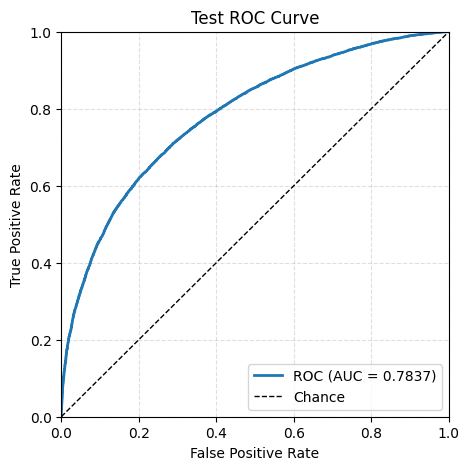

AUC (test): 0.783735


In [16]:
# ROC/AUC
from sklearn.metrics import roc_curve, roc_auc_score

model.eval()
y_true, y_score = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits, _, _ = model(xb)
        probs = F.softmax(logits, dim=1)[:, 1]   # P(class=1)
        y_true.append(yb.numpy())
        y_score.append(probs.cpu().numpy())

y_true  = np.concatenate(y_true)
y_score = np.concatenate(y_score)

# ROC + AUC
fpr, tpr, thr = roc_curve(y_true, y_score)
auc_value = roc_auc_score(y_true, y_score)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, lw=2, label=f'ROC (AUC = {auc_value:.4f})')
plt.plot([0,1], [0,1], 'k--', lw=1, label='Chance')
plt.xlim([0,1]); plt.ylim([0,1])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Test ROC Curve')
plt.legend(loc='lower right'); plt.grid(True, ls='--', alpha=0.4)
plt.show()

print(f"AUC (test): {auc_value:.6f}")

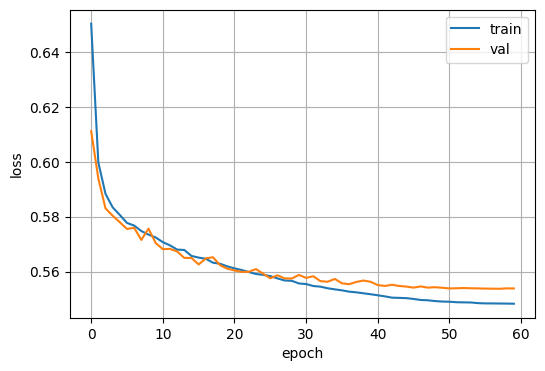

In [11]:
#@title 8. Plot training / validation loss [average running time in google colab for 60 epochs: ~0 sec]
plt.figure(figsize=(6,4))
plt.plot(history['train'], label='train'); plt.plot(history['val'], label='val')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.grid(); plt.show()

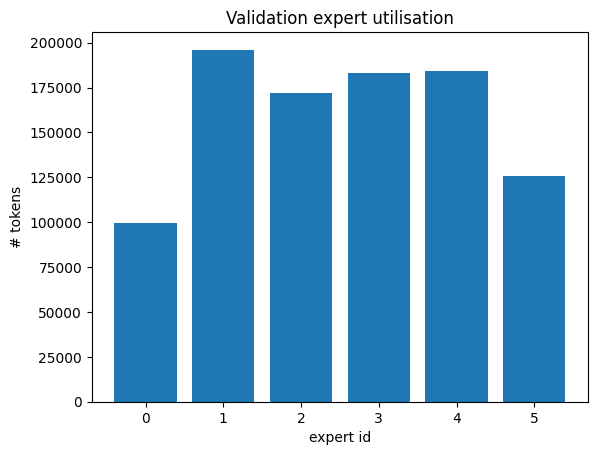

In [13]:
#@title 9. Expert-utilisation histogram (validation) [average running time in google colab for 60 epochs: ~1 sec]
import torch, matplotlib.pyplot as plt

model.eval(); exp_all = []
with torch.no_grad():
    for xb, _ in val_loader:
        xb = xb.to(device)

        # forward pass with routing traces
        _, _, (_, traces) = model(xb, explain=True)
        gates, idx = traces[-1]            # last layer → shapes (T, k)

        # pick the expert with the largest gate weight for every token
        top_pos = gates.argmax(dim=1, keepdim=True)      # (T,1)
        exp_ids = idx.gather(1, top_pos).squeeze(1)      # (T,)

        exp_all.extend(exp_ids.cpu().tolist())

num_exp = model.blocks[0].moe.router.wg.out_features
counts  = torch.bincount(torch.tensor(exp_all), minlength=num_exp)

plt.bar(range(num_exp), counts)
plt.xlabel('expert id'); plt.ylabel('# tokens')
plt.title('Validation expert utilisation')
plt.show()

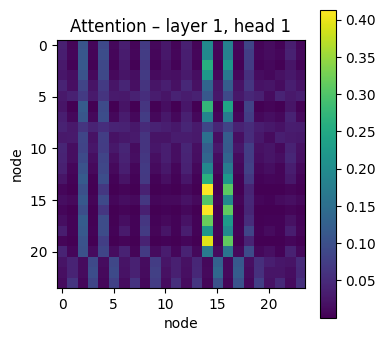

Dominant expert id for each of the 23 nodes:
[5, 2, 2, 5, 2, 4, 5, 2, 2, 3, 5, 1, 5, 3, 2, 5, 2, 5, 2, 3, 5, 4, 1, 1]


In [14]:
#@title 10. Attention heat-map & expert colours for one event [average running time in google colab for 60 epochs: ~0 sec]

layer = 0        # which transformer layer to inspect
head  = 0        # which attention head (0 … H-1)

# one validation event
sample_x, sample_y = ds_val[0]
sample_x = sample_x.unsqueeze(0).to(device)    # (1,24,1)

model.eval()
with torch.no_grad():
    logits, _, (atts, traces) = model(sample_x, explain=True)

# ---------- attention heat-map ----------------------------------------
att_map = atts[layer][0, head].cpu()           # (N, N)
plt.figure(figsize=(4,4))
plt.imshow(att_map, cmap='viridis')
plt.colorbar()
plt.title(f'Attention – layer {layer+1}, head {head+1}')
plt.xlabel('node'); plt.ylabel('node'); plt.show()

# ---------- dominant expert per node ----------------------------------
gates, idx = traces[layer]                     # shapes (T=N, k)
top_pos = gates.argmax(dim=1)                  # (N,) best of k experts
dom_exp = idx[torch.arange(idx.size(0)), top_pos].cpu()  # (N,)

print('Dominant expert id for each of the 23 nodes:')
print(dom_exp.tolist())